## All Functions for Ext Guinier Calculations and Plots


### Uploading and Reading Data for Analyses

In [3]:
import pandas as pd
import os
import sys,math

from scipy import optimize
from scipy import special
from scipy.optimize import curve_fit
from scipy import stats 

import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from collections import OrderedDict
from collections import defaultdict

import re

import seaborn as sns
import pickle


In [4]:
# Class to Read Data

class DataProcessor:
    def __init__(self, base_dir, save_dir):
        self.base_dir = base_dir
        self.save_dir = save_dir  # Directory to save the processed files
        self.dataframes = []

    def extract_last_number(self, file_name):
        match = re.search(r'(\d+)(?!.*\d)', file_name)
        return match.group(1) if match else None

    def get_concentration(self, file_name):
        if '0_5mg_mL' in file_name:
            return '0.5mg/mL'
        elif '1_5mg_mL' in file_name:
            return '1.5mg/mL'
        elif '1mg_mL' in file_name:
            return '1.0mg/mL'
        elif '2mg_mL' in file_name:
            return '2.0mg/mL'
        elif '3mg_mL' in file_name:
            return '3.0mg/mL'
        elif '3mg_ml' in file_name:
            return '1.7mg/mL'
        elif '4mg_ml' in file_name:
            return '2.3mg/mL'
        elif '5mg_ml' in file_name:
            return '2.8mg/mL'
        return 'unknown'

    def get_addition(self, file_name):
        if 'EPI' in file_name:
            return 'EPI-001'
        elif 'DMSO' in file_name or 'dmso' in file_name:
            return 'DMSO'
        return 'buffer'

    def sanitize_file_name(self, file_name):
        sanitized_name = re.sub(r'[\/:*?"<>|]', '_', file_name)
        sanitized_name = sanitized_name.replace(' ', '_')
        return sanitized_name[:255]

    def save_dataframe(self, df, file_name):
        # Construct the full save path
        save_file_name = f"{file_name}_Processed.csv"
        save_path = os.path.join(self.save_dir, save_file_name)
        # Save the DataFrame as a CSV
        df.to_csv(save_path, index=False)
        # print(f"Saved DataFrame to {save_path}")

    def process_file(self, file_path, save=False):
            file_name = os.path.basename(file_path)

            # Read the data
            df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#')
            df = df.rename(columns={0: 'q', 1: 'I(q)', 2: 'Error'})

            # Extract the last number from the file name
            last_number = self.extract_last_number(file_name)

            # Determine custom_name based on the file name prefix
            if file_name.startswith('aa'):
                custom_name = 'W397A/W433A'
            elif file_name.startswith('WT'):
                custom_name = 'WT'
            else:
                custom_name = 'unknown'

            # Determine concentration and addition
            concentration = self.get_concentration(file_name)
            addition = self.get_addition(file_name)

            # Create save file name
            save_file_name = f"{custom_name}_{concentration}_{addition}_{last_number}"
            sanitized_save_file_name = self.sanitize_file_name(save_file_name)

            # Create legend name and commonality
            legend_name = f"{custom_name}_{concentration}_{addition}"
            common_name = f"{custom_name}, {concentration}, +{addition}"

            # Attach attributes to the DataFrame
            df.attrs['file_name'] = file_name
            df.attrs['repetition'] = last_number
            df.attrs['custom_name'] = custom_name
            df.attrs['concentration'] = concentration
            df.attrs['addition'] = addition
            df.attrs['save_file_name'] = sanitized_save_file_name
            df.attrs['legend_name'] = legend_name
            df.attrs['commonality'] = common_name

            # Conditionally save the DataFrame only if the `save` flag is True
            if save:
                self.save_dataframe(df, sanitized_save_file_name)

            # Store DataFrame in list for later processing
            self.dataframes.append(df)

    def process_files(self, file_name=None, save=False):
        if file_name:
            file_path = os.path.join(self.base_dir, file_name)
            self.process_file(file_path, save)
        else:
            for file_name in os.listdir(self.base_dir):
                if file_name.endswith('.dat'):
                    file_path = os.path.join(self.base_dir, file_name)
                    self.process_file(file_path, save)

    def get_dataframes(self):
        return self.dataframes


In [6]:
# Example usage
base_dir = '/Users/natalieloui/Library/CloudStorage/OneDrive-DartmouthCollege/Robustelli Laboratory/SAXS Results/Raw Data/_s data/08062024/'
save_dir = '/Users/natalieloui/Library/CloudStorage/OneDrive-DartmouthCollege/Robustelli Laboratory/SAXS Results/Raw Data/_s data/08062024/Processed AA/'
processor = DataProcessor(base_dir, save_dir)
# Call process_files without saving by passing save=False
selected_file = 'aa_1mg_mL_1_s.dat'
processor.process_files(file_name=selected_file, save=False)
# Access processed DataFrames
dataframes = processor.get_dataframes()

ex_df=dataframes[0]
print(f"Attributes for {ex_df.attrs['file_name']}:")
print(f"Repetition: {ex_df.attrs['repetition']}, Custom Name: {ex_df.attrs['custom_name']}, Commonality: {ex_df.attrs['commonality']}")
ex_df

Attributes for aa_1mg_mL_1_s.dat:
Repetition: 1, Custom Name: W397A/W433A, Commonality: W397A/W433A, 1.0mg/mL, +buffer


,q,I(q),Error
0,0.005,0.480000,1.885000
1,0.006,0.604900,0.691200
2,0.007,0.390900,0.422300
3,0.008,0.743000,0.268900
4,0.009,0.589400,0.188700
...,...,...,...
269,3.070,0.004142,0.005103
270,3.100,0.003332,0.006875
271,3.130,0.003510,0.008460
272,3.160,0.002587,0.009047


### Calculated Extended Guinier and Residuals

In [7]:
def Ext_Guinier_residuals(df, Nres, b_Angstrom, nu_init, Rg_input, q_start_index=0):
    def Rg_nu(b, N, nu):
        g = 1.1615
        return (g * (g + 1) / (2 * (g + 2 * nu) * (g + 2 * nu + 1))) ** 0.5 * b * N ** nu

    def chisq_extguin(parms, q, log_Iq, Nres, b):
        nu = parms[0]
        log_I0 = parms[1]
        Rg = Rg_nu(b, Nres, nu)

        log_Iq_fit = log_I0 - 1 / 3 * q ** 2 * Rg ** 2 + 0.0479 * (nu - 0.212) * q ** 4 * Rg ** 4
        dI = log_Iq_fit - log_Iq
        return np.dot(dI, dI)

    if q_start_index >= len(df):
        return None

    q = df['q'].values
    Iq = df['I(q)'].values
    Rg_init = Rg_nu(b_Angstrom, Nres, 0.6)
    # print(f"Rg calculated initial is {Rg_init}")
    if len(q) == 0 or len(Iq) == 0:
        return None
    if q_start_index >= len(df):
        return None
    
    qcut = 2.0 / Rg_input
    q_lt_cut = (q >= q[q_start_index]) & (q < qcut)    
    qrange = q[q_lt_cut]
    log_Iq = np.log(Iq[q_lt_cut])
    error_filtered = df['Error'].values[q_lt_cut]
    
    if len(qrange) == 0 or len(log_Iq) == 0:
        return None
    
    log_I0_init = log_Iq[0]
    init_parm = [nu_init, log_I0_init]

    opt_parm = optimize.fmin(chisq_extguin, init_parm, args=(qrange, log_Iq, Nres, b_Angstrom), disp=False)
    nu_final, log_I0_final = opt_parm
    Rg_final = Rg_nu(b_Angstrom, Nres, nu_final)

    log_Iq_fit = log_I0_final - 1 / 3 * qrange ** 2 * Rg_final ** 2 + 0.0479 * (nu_final - 0.212) * qrange ** 4 * Rg_final ** 4

    df_cut = df[q_lt_cut].copy()
    df_cut['Ext_Guinier_q_squared'] = qrange ** 2
    df_cut['Ext_Guinier_log_Iq'] = log_Iq
    df_cut['Ext_Guinier_log_Iq_fit'] = log_Iq_fit
    df_cut['Ext_Guinier_delta_Iq']=log_Iq_fit-log_Iq
    df_cut['Ext_Guinier_normalized_delta_Iq']=(log_Iq_fit-log_Iq) / error_filtered

    return df_cut, Rg_final, nu_final, qrange


In [8]:
Nres=121
b_Angstrom=5.5
nu_init=0.5
Rg_input=31

df_cut, Rg_final, nu_final, qrange =Ext_Guinier_residuals(ex_df, Nres, b_Angstrom, nu_init, Rg_input, q_start_index=0)

print(f"Rg expected is {Rg_input} A^-1. Rg_final calculated by Extended Guinier is {Rg_final} A^-1.")
df_cut

Rg expected is 31 A^-1. Rg_final calculated by Extended Guinier is 27.74499864316567 A^-1.


,q,I(q),Error,Ext_Guinier_q_squared,Ext_Guinier_log_Iq,Ext_Guinier_log_Iq_fit,Ext_Guinier_delta_Iq,Ext_Guinier_normalized_delta_Iq
0,0.005,0.4800,1.885000,0.000025,-0.733969,-0.499580,0.234389,0.124345
1,0.006,0.6049,0.691200,0.000036,-0.502692,-0.502396,0.000296,0.000428
2,0.007,0.3909,0.422300,0.000049,-0.939304,-0.505723,0.433581,1.026713
3,0.008,0.7430,0.268900,0.000064,-0.297059,-0.509557,-0.212498,-0.790248
4,0.009,0.5894,0.188700,0.000081,-0.528650,-0.513898,0.014753,0.078180
5,0.010,0.6431,0.159000,0.000100,-0.441455,-0.518743,-0.077288,-0.486089
6,0.011,0.7050,0.121100,0.000121,-0.349557,-0.524092,-0.174534,-1.441239
7,0.012,0.5370,0.089090,0.000144,-0.621757,-0.529941,0.091817,1.030606
8,0.013,0.5722,0.071000,0.000169,-0.558267,-0.536288,0.021979,0.309564
9,0.014,0.5434,0.059410,0.000196,-0.609910,-0.543130,0.066779,1.124038


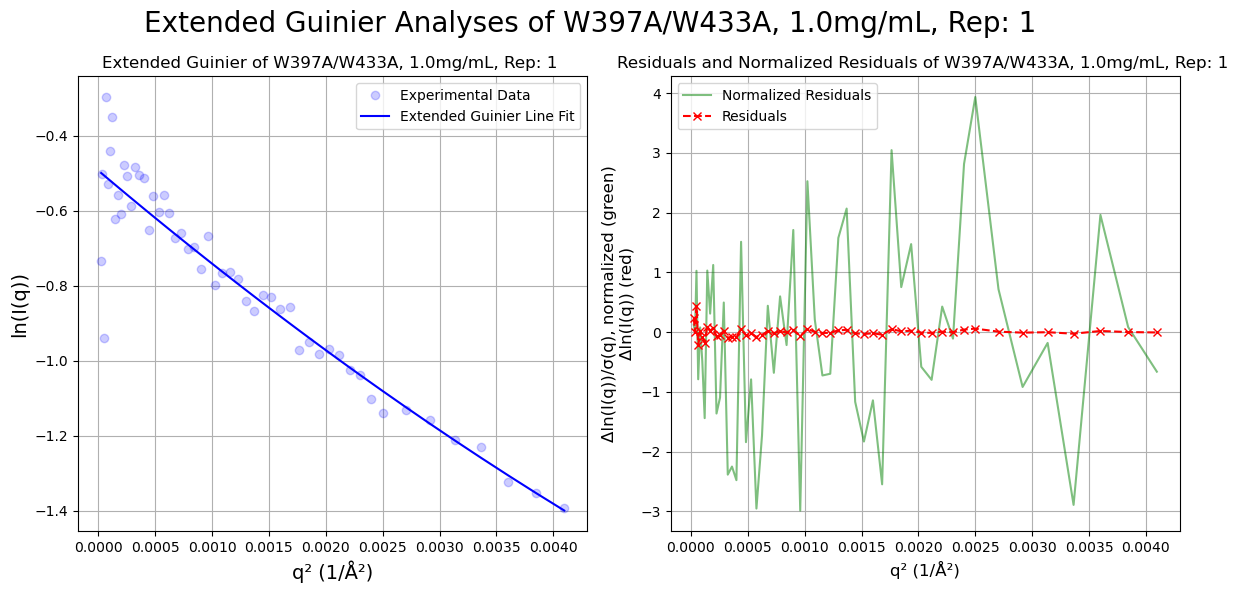

In [9]:
title_name=(f"{df_cut.attrs['custom_name']}, {df_cut.attrs['concentration']}, Rep: {df_cut.attrs['repetition']} ")

# Initialize the plot with subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False, sharex=False)  # 1 row, 3 columns, sharey=True for same y-axis scale

# Plot the average in a distinct color (red)
axs[0].plot(df_cut['Ext_Guinier_q_squared'], df_cut['Ext_Guinier_log_Iq'], marker='o',linestyle='None', alpha=0.2,label='Experimental Data', color='b')
axs[0].plot(df_cut['Ext_Guinier_q_squared'], df_cut['Ext_Guinier_log_Iq_fit'], linestyle='-', color='b', label='Extended Guinier Line Fit')
axs[0].set_title(f"Extended Guinier of {title_name}")
axs[0].set_xlabel('q² (1/Å²)', fontsize=14)
axs[0].set_ylabel('ln(I(q))', fontsize=14)
axs[0].grid(True)
axs[0].legend()

# Plot the average in a distinct color (red)
axs[1].plot(df_cut['Ext_Guinier_q_squared'], df_cut['Ext_Guinier_normalized_delta_Iq'], linestyle='-', color='g', alpha=0.5, label='Normalized Residuals')
axs[1].plot(df_cut['Ext_Guinier_q_squared'], df_cut['Ext_Guinier_delta_Iq'], marker='x', linestyle='--', color='r', label='Residuals')
axs[1].set_xlabel('q² (1/Å²)', fontsize=12)
axs[1].set_ylabel('Δln(I(q))/σ(q), normalized (green)\nΔln(I(q)) (red)', fontsize=12)
axs[1].set_title(f"Residuals and Normalized Residuals of {title_name}")
axs[1].grid(True)    
axs[1].legend()

# Customize the plot
fig.suptitle(f"Extended Guinier Analyses of {title_name}", fontsize=20)

plt.tight_layout()
plt.show()

### Iterative Calculation of Radius of Gyration

In [10]:
def run_ext_guinier_over_qrange(Nres, df, b_Angstrom, nu_init, Rg_input):
    results = []
    df_cut_attributes = None
    
    for q_start_index in range(len(df)):
        # Perform analysis (assuming Ext_Guinier is a function that returns results)
        result = Ext_Guinier_residuals(df,Nres, b_Angstrom, nu_init,Rg_input, q_start_index)
        if result is None:
            print(f"Ext_Guinier returned None for q_start_index={q_start_index}")
            break

        # Call Ext_Guinier for the current q_start_index
        df_cut, Rg_final, nu_final, qrange = Ext_Guinier_residuals( df,Nres, b_Angstrom, nu_init, Rg_input, q_start_index)
        
        # Record the number of df points and the Rg_final value, along with additional columns
        results.append({
            "q_start_index": q_start_index,
            "Rg_final": Rg_final,
            "Number of Data Points": len(qrange)
        })
        df_cut_attributes = df_cut.attrs

    # Convert the results into a DataFrame
    df_results = pd.DataFrame(results)
    if df_cut_attributes:
        df_results.attrs = df_cut_attributes
    
    return df_results, df_cut

In [11]:
Nres=121
b_Angstrom=5.5
nu_init=0.5
Rg_input=31

df_results, df_cut = run_ext_guinier_over_qrange(Nres, ex_df,b_Angstrom,nu_init,Rg_input)
print(df_results.attrs)

print(df_results.head())

Ext_Guinier returned None for q_start_index=53
{'file_name': 'aa_1mg_mL_1_s.dat', 'repetition': '1', 'custom_name': 'W397A/W433A', 'concentration': '1.0mg/mL', 'addition': 'buffer', 'save_file_name': 'W397A_W433A_1.0mg_mL_buffer_1', 'legend_name': 'W397A/W433A_1.0mg/mL_buffer', 'commonality': 'W397A/W433A, 1.0mg/mL, +buffer'}
   q_start_index   Rg_final  Number of Data Points
0              0  27.744999                     53
1              1  28.144443                     52
2              2  28.167178                     51
3              3  29.018769                     50
4              4  28.666867                     49


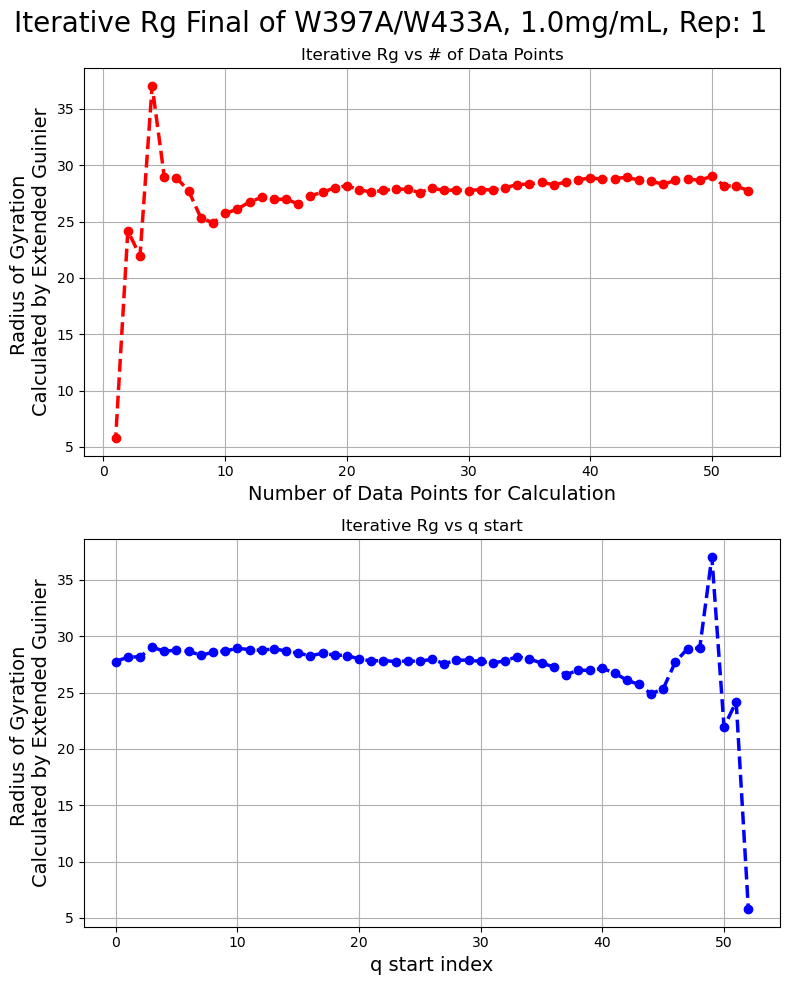

In [12]:
it_df=df_results
title_name=(f"{it_df.attrs['custom_name']}, {it_df.attrs['concentration']}, Rep: {it_df.attrs['repetition']} ")

# Initialize the plot with subplots side by side
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharey=True, sharex=False)  # 1 row, 3 columns, sharey=True for same y-axis scale

# Plot the average in a distinct color (red)
axs[0].plot(it_df['Number of Data Points'], 
         it_df['Rg_final'], 
         label='Iterative Rg vs # of Data Points', 
         marker='o', linestyle='--', color='red', linewidth=2.5)
axs[0].set_title('Iterative Rg vs # of Data Points')
axs[0].set_xlabel('Number of Data Points for Calculation', fontsize=14)
axs[0].set_ylabel('Radius of Gyration \nCalculated by Extended Guinier', fontsize=14)
axs[0].grid(True)  

# Plot the average in a distinct color (red)
axs[1].plot(it_df['q_start_index'], 
         it_df['Rg_final'], 
         label='Iterative Rg vs # of Data Points', 
         marker='o', linestyle='--', color='blue', linewidth=2.5)
axs[1].set_title('Iterative Rg vs q start')
axs[1].grid(True)    
axs[1].set_xlabel('q start index', fontsize=14)
axs[1].set_ylabel('Radius of Gyration \nCalculated by Extended Guinier', fontsize=14)


# Customize the plot

fig.suptitle(f"Iterative Rg Final of {title_name}", fontsize=20)

plt.tight_layout()
plt.show()